In [1]:
import numpy as np
import scipy as sp
import sklearn as sk
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from fbprophet import Prophet as prt

# Data
## Importing the data

In [2]:
df = pd.read_csv('data/climdiv_national_year.csv')

In [3]:
df_temp = df.drop('temp', axis=1)

df_temp = df_temp.dropna()
df_temp.isnull().sum()

df_temp['year'] = pd.to_datetime(df_temp['year'].astype(str))
df_temp['year'] = df_temp['year'].dt.strftime('%Y-%m-%d')

df_temp_lbl = df_temp

df_temp = df_temp.set_index('year')

# split data into train and test-sets
#frac = 0.80
#num_frac = int(df_temp.shape[0] * frac)
#train, test = df_temp[0:num_frac+1], df_temp[num_frac::]
train, test = df_temp[0:-20], df_temp[-20::]

df_temp.head()

,tempc
year,
1895-01-01,10.187500
1896-01-01,11.107407
1897-01-01,10.864815
1898-01-01,10.795370
1899-01-01,10.560648


## Data cleaning

The provided data was already significanlty clean, thus no more steps were required.

## EDA

/home/robert/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='tempc', ylabel='Density'>

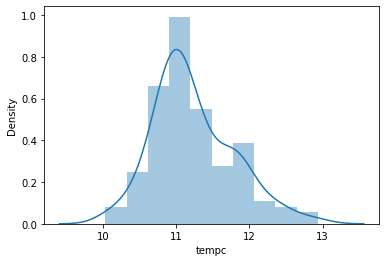

In [4]:
sns.distplot(df_temp['tempc'])

Text(0, 0.5, 'Temp [C]')

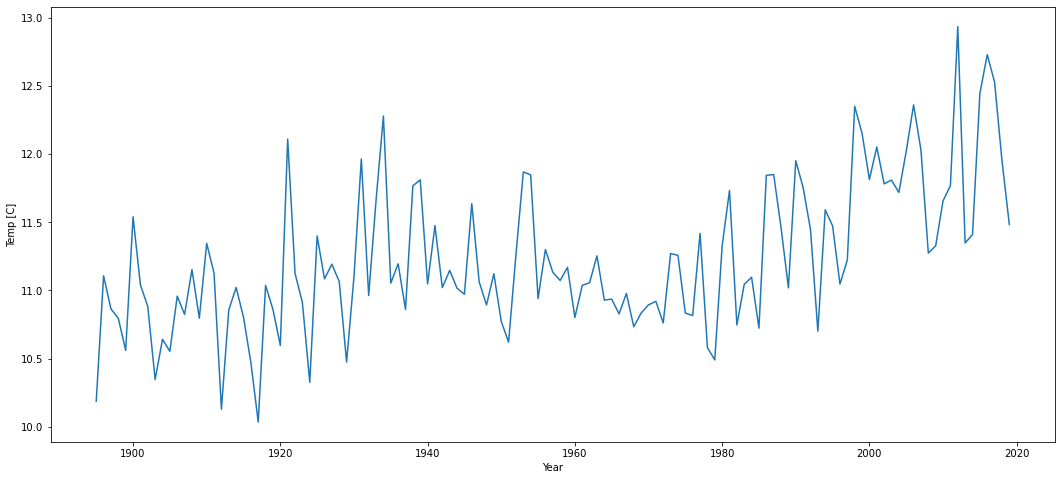

In [5]:
plt.figure(figsize=(18, 8))
plt.plot(df['year'], df['tempc'])
plt.xlabel('Year')
plt.ylabel('Temp [C]')

In [6]:
print(np.average(df['tempc']), np.std(df['tempc']))

11.231407407407408 0.5462242745996058


# Model selection
## FB Prophet model

In [7]:
df_temp

,tempc
year,
1895-01-01,10.187500
1896-01-01,11.107407
1897-01-01,10.864815
1898-01-01,10.795370
1899-01-01,10.560648
...,...
2015-01-01,12.445370
2016-01-01,12.730556
2017-01-01,12.528704


In [8]:
df_temp_lbl = df_temp_lbl.rename(columns = {'year': 'ds', 'tempc': 'y'})
#df_temp_lbl['ds'] = pd.to_datetime(df_temp_lbl['ds'])
#df_temp_lbl = df_temp.rename_axis('ds') #df_temp.Index.rename('ds')
#df_temp_lbl = df_temp_lbl.rename(columns = {'tempc': 'y'})
#df_temp_lbl = df_temp_lbl.

df_temp_lbl.head()

,ds,y
0,1895-01-01,10.187500
1,1896-01-01,11.107407
2,1897-01-01,10.864815
3,1898-01-01,10.795370
4,1899-01-01,10.560648


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


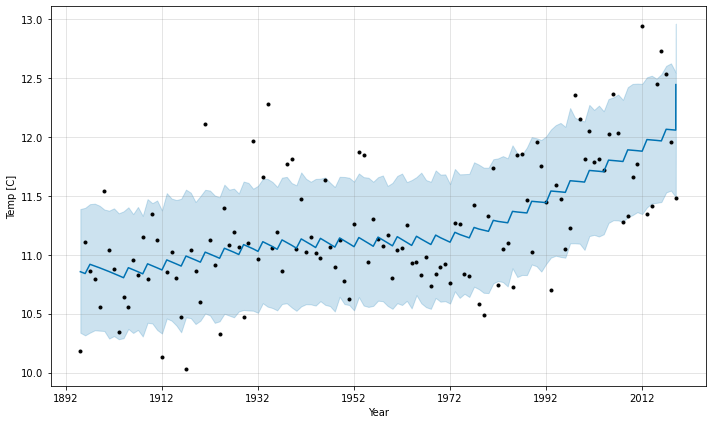

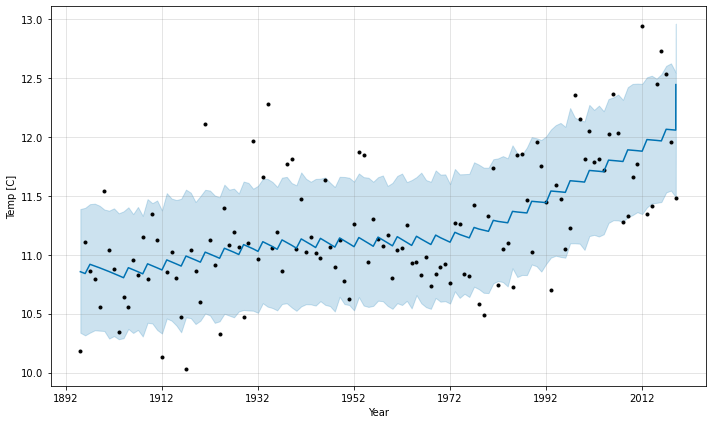

In [9]:
model_temp = prt(yearly_seasonality=True)
model_temp.fit(df_temp_lbl)

future_temp = model_temp.make_future_dataframe(periods=5)
forecast_temp = model_temp.predict(future_temp)

model_temp.plot(forecast_temp, xlabel='Year', ylabel='Temp [C]')

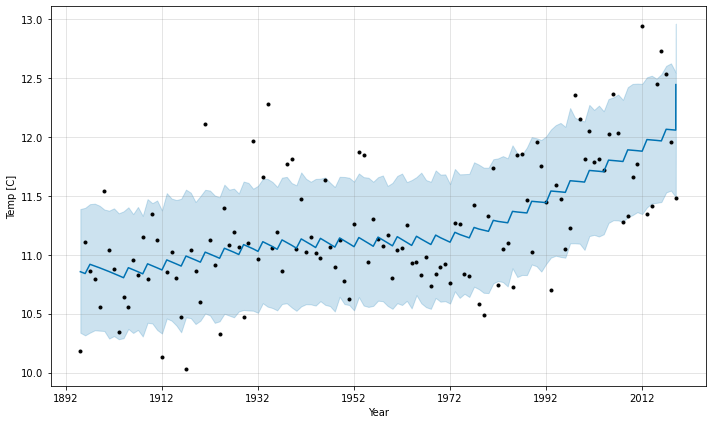

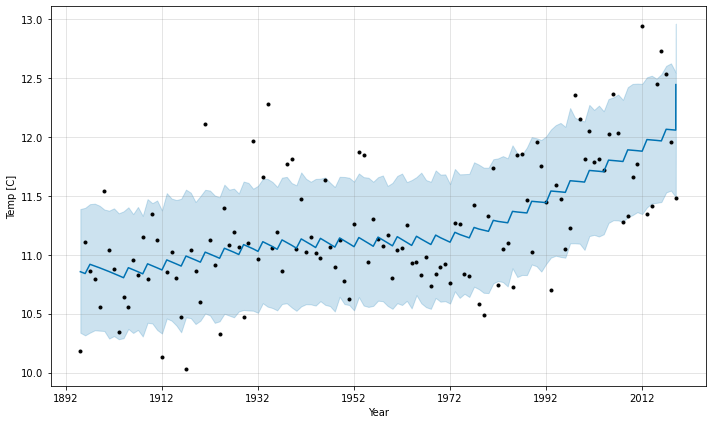

In [10]:
model_temp.plot(forecast_temp, xlabel='Year', ylabel='Temp [C]')

## LSTM model selection

In [11]:
sk.__version__

'0.23.2'

In [12]:
import tensorflow as tf
from tensorflow import keras

In [13]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [14]:
time_steps = 10
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train.tempc, time_steps)
X_test, y_test = create_dataset(test, test.tempc, time_steps)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(95, 10, 1) (95,)
(10, 10, 1) (10,)


In [19]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2])
))
#model.add(keras.layers.LSTM(128, batch_input_shape=(20, X_train.shape[1], X_train.shape[2]), stateful=True))

#model.add(keras.layers.LSTM(128, batch_input_shape=(16, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(keras.layers.Dense(128, activation='relu'))
##model.add(LSTM(16, batch_input_shape=(16, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(keras.layers.Dense(1))
##model.add(keras.layers.Dense(units=1))
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
#model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(0.001))

In [20]:
#tf.keras.backend.clear_session()

In [21]:
history = model.fit(
    X_train, y_train,
    epochs=1000,
    batch_size=20,
    validation_split=0.1,
    verbose=0,
    shuffle=False
)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 83,201
Trainable params: 83,201
Non-trainable params: 0
_________________________________________________________________


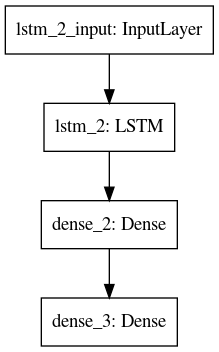

In [23]:
tf.keras.utils.plot_model(model)

In [24]:
y_pred = model.predict(X_test)
#y_pred

In [25]:
y_pred

array([[11.216518 ],
       [11.271034 ],
       [11.290572 ],
       [11.488992 ],
       [11.230595 ],
       [11.231852 ],
       [11.409115 ],
       [11.4658575],
       [11.441997 ],
       [11.350359 ]], dtype=float32)

In [26]:
pred_tempc = []
for i in range(20):
    pred_tempc.append(None)
    
pred_tempc

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [27]:
test['pred_tempc'] = pred_tempc

for j in range(10):
    test['pred_tempc'][-j] = y_pred[-j]

<ipython-input-27-ec0c1dfbb687>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_tempc'] = pred_tempc
<ipython-input-27-ec0c1dfbb687>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_tempc'][-j] = y_pred[-j]
/home/robert/anaconda3/envs/py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(c

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

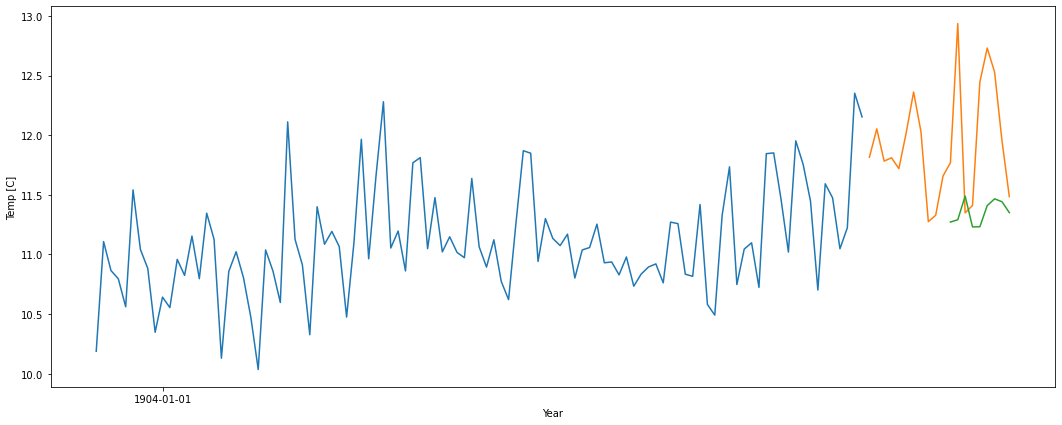

In [30]:
plt.figure(figsize=(18,7))
plt.ylabel('Temp [C]')
plt.xlabel('Year')
plt.plot(train)
plt.plot(test)
plt.xticks(np.arange(min(train.tempc)-1, max(test.tempc)+1, 105))
plt.show()

## SARIMA time series model

In [ ]:
df_temp = df.drop('temp', axis=1)
df_temp = df_temp.dropna()
df_temp.isnull().sum()
df_temp['year'] = pd.to_datetime(df_temp['year'].astype(str))
df_temp = df_temp.set_index('year')
df_temp

In [ ]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import matplotlib
import pmdarima as pm

In [ ]:
ts_year_avg = df_temp['tempc'].resample('YS').mean()

if len(ts_year_avg) == 1:
    delta = pd.Timedelta(days=1)
    lims = [ts_year_avg.index[0] - delta, ts_year_avg.index[0] + delta]
else:
    lims = [None, None]

ts_year_avg.plot(figsize = (15, 6), xlim=lims)
plt.show()

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(ts_year_avg, model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

print(adf_test(ts_year_avg))

In [ ]:
ts_t_adj = ts_year_avg - ts_year_avg.shift(5)
ts_t_adj = ts_t_adj.dropna()
ts_t_adj.plot()

print(adf_test(ts_year_avg))

In [ ]:
ts_s_adj = ts_t_adj - ts_t_adj.shift(15)
ts_s_adj = ts_s_adj.dropna()
ts_s_adj.plot()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_s_adj)
matplotlib.pyplot.show()
plot_pacf(ts_s_adj)
matplotlib.pyplot.show()

In [ ]:
p = range(0, 3)
d = range(1,2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [ ]:
#ARIMA(0, 1, 1)x(2, 1, 0, 12)
mod = sm.tsa.statespace.SARIMAX(ts_s_adj,
                                order=(0, 1, 1),
                                seasonal_order=(2, 1, 0, 12))
results = mod.fit(method = 'powell')
print(results.summary().tables[1])

In [ ]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2005-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = ts_s_adj.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('AQI')
plt.legend()
plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = ts_s_adj['2005-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

# Comparison between different model metrics

# Summary and final findings

In [ ]:
from sklearn import preprocessing

#import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Masking
from tensorflow.keras.layers import LSTM

#tf.config.experimental.set_memory_growth(gpu, True)

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.values.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.values.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(Masking(mask_value=0))
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

# load dataset
#series = read_csv('shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# transform data to be stationary
raw_values = df['tempc'].values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# repeat experiment
repeats = 3
error_scores = list()
for r in range(repeats):
    # fit the model
    lstm_model = fit_lstm(train_scaled, 1, 3000, 6)
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)
    # walk-forward validation on the test data
    predictions = list()
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
    # report performance
    rmse = np.sqrt(sk.metrics.mean_squared_error(raw_values[-num_frac:], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)

# summarize results
results = pd.DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
plt.show()